In [3]:
# Common
import os
import keras 
import numpy as np
import tensorflow as tf
import time
import random

# Data
from keras.preprocessing.image import ImageDataGenerator as IDG
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import shutil

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Pre-Trained Models
from tensorflow.keras.applications import VGG19

# Model
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply, Input, Flatten

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model viz
from tensorflow.keras.utils import plot_model
from tensorflow import one_hot
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
def print_weights(model):
    trainable = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    print(f'trainable: {trainable}, non-trainable: {non_trainable}')

In [5]:
def print_time(timestamp):
    print('Time : ', timestamp, ' sec')

In [9]:
# root_path = '/content/drive/MyDrive/WDZD/dataset/'
root_path = '/kaggle/input/weather-dataset/dataset'

class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

print(f"Total No. of Classes : {n_classes}")

Total No. of Classes : 11


In [5]:
class_dis = [len(os.listdir(root_path + "/" + name)) for name in class_names]
class_dis

[698, 851, 475, 639, 591, 377, 526, 232, 1160, 692, 621]

In [6]:
out_path = '/kaggle/working/weather-dataset/dataset'
train_val_test = ['train','validation', 'test']
AUG_PROB = 0.8


seq = iaa.Sequential([
    iaa.Fliplr(0.7),
    iaa.Crop(percent=(0, 0.1)),            
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),        
    iaa.ContrastNormalization((0.75, 1.5))
])


categories = os.listdir(root_path)
for category in categories:
    category_folder = os.path.join(root_path, category)
    if os.path.isdir(category_folder):
        image_files = [f for f in os.listdir(category_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for image_file in image_files:
            image_path = os.path.join(category_folder, image_file)
            
            where = random.random()
            set_name = train_val_test[0] if where < 0.7 else (train_val_test[1] if where < 0.9 else train_val_test[2])
            
            augument = random.random() < AUG_PROB
            
            try:
                image = cv2.imread(image_path)

                base_name = os.path.splitext(image_file)[0]
                if augument:                
                    augmented_image = seq.augment_image(image)
                    base_name = base_name + '_aug'
                base_name = base_name + os.path.splitext(image_file)[1]
                output_path = os.path.join(out_path, set_name, category)
                if not os.path.exists(output_path):
                    os.makedirs(output_path)
                output_path = os.path.join(output_path,base_name)
#                 print(output_path)
                if augument: cv2.imwrite(output_path, augmented_image)
                cv2.imwrite(output_path, image)
            except:
                print("Some error with image:" + image_path)
                continue
            
             


/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Some error with image:/kaggle/input/weather-dataset/dataset/fogsmog/4514.jpg
Some error with image:/kaggle/input/weather-dataset/dataset/snow/1187.jpg


In [7]:
sets_tvt = []
for set_name in train_val_test:
    class_dis = [len(os.listdir(out_path + "/" + set_name + "/" + name)) for name in class_names]
    sets_tvt.append(class_dis)
    print(class_dis)

[475, 606, 331, 448, 424, 240, 379, 164, 851, 498, 449]
[155, 148, 91, 127, 117, 94, 92, 46, 205, 118, 120]
[68, 96, 53, 64, 50, 43, 55, 22, 104, 76, 51]


In [8]:
for class_dis_ in sets_tvt:
    fig = px.pie(names=class_names, values=class_dis_, title="Class Distribution")
    fig.update_layout({'title':{'x':0.5}})
    fig.show()

In [29]:
# Initialize DataGenerator
train_gen = IDG(rescale=1./255)

# Load Data
train_ds = train_gen.flow_from_directory(out_path + "/" + train_val_test[0], target_size=(256,256), class_mode="binary", subset='training', shuffle=True, batch_size=32)
valid_ds = train_gen.flow_from_directory(out_path + "/" + train_val_test[1], target_size=(256,256), class_mode="binary", subset='training', shuffle=True, batch_size=32)
test_ds = train_gen.flow_from_directory(out_path + "/" + train_val_test[2], target_size=(256,256), class_mode="binary", subset='training', shuffle=True, batch_size=682)

Found 4865 images belonging to 11 classes.
Found 1313 images belonging to 11 classes.
Found 682 images belonging to 11 classes.


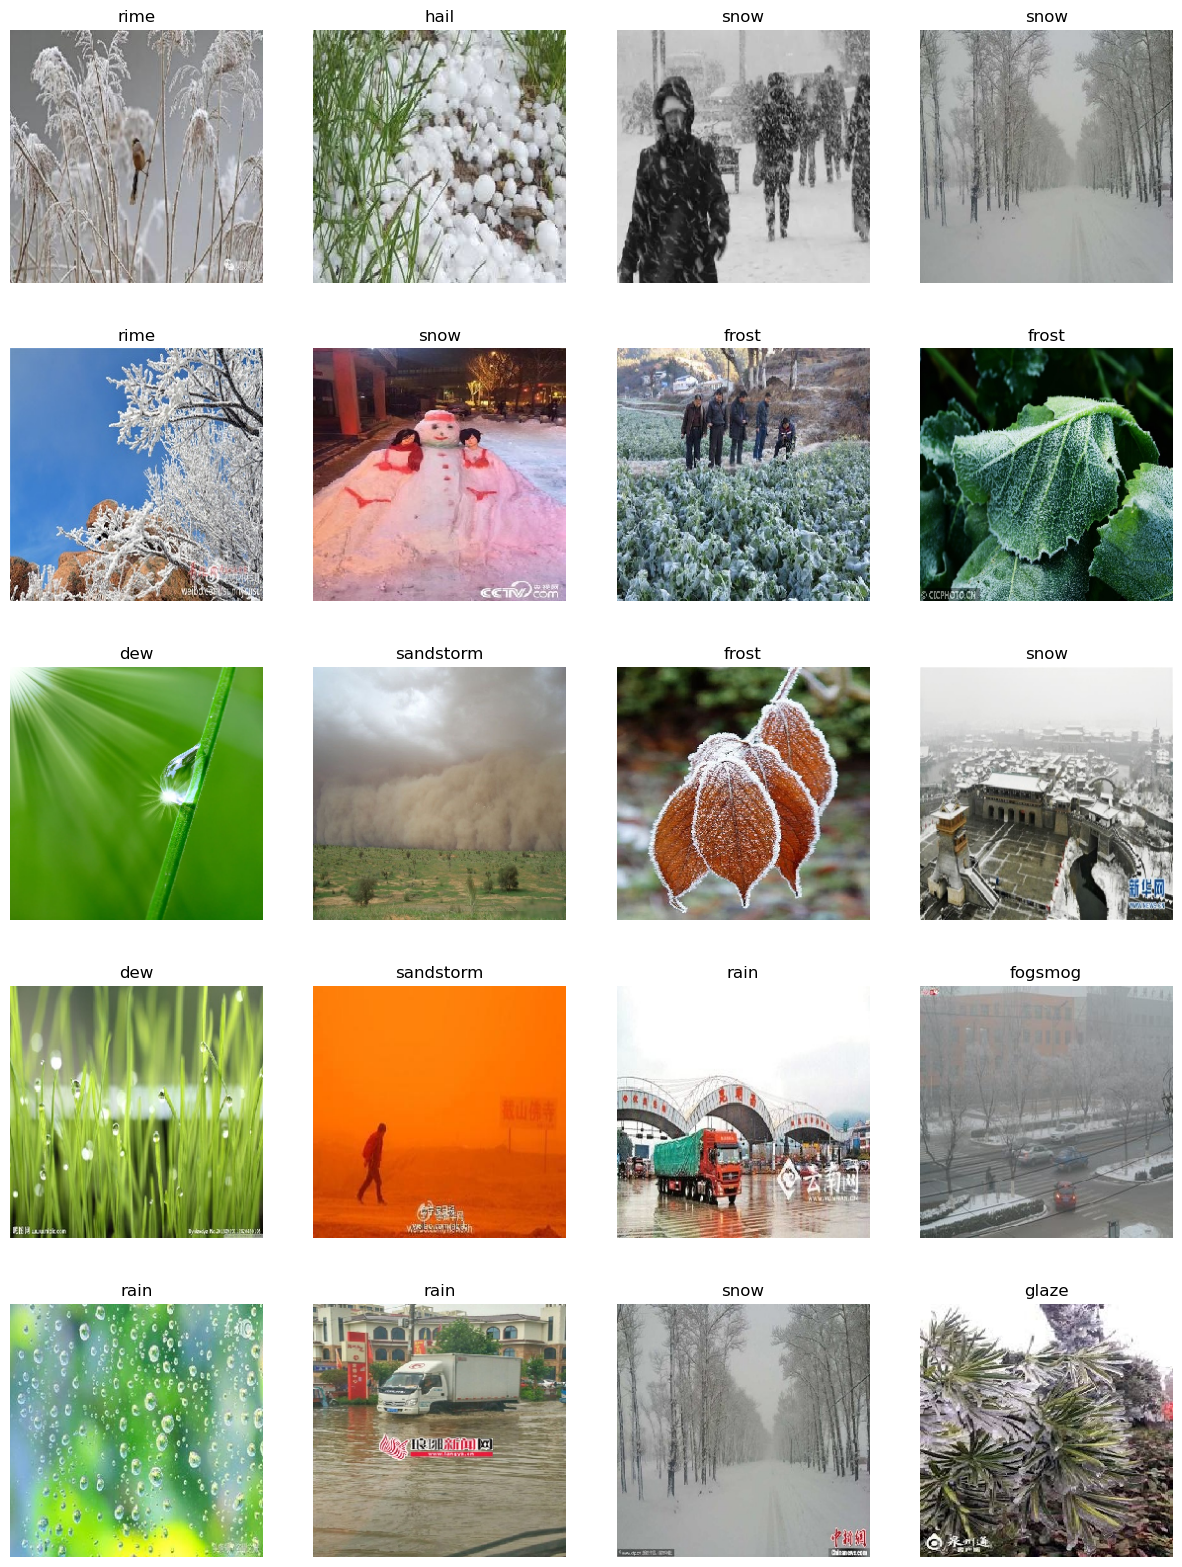

In [10]:
i=1
plt.figure(figsize=(15,20))
for images, labels in train_ds:
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])

    plt.subplot(5, 4, i)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')

    i+=1
    if i>=21: break

plt.show()

In [11]:
vgg19_loaded = VGG19(include_top=True)
vgg19_loaded.trainable = False

574710816/574710816 [==============================] - 18s 0us/step


### Sprawdzenie działania wytrenowanego modelu na naszych danych

In [12]:
from skimage.transform import resize
new_size = (224, 224)

imageArr = []
labelArr = []
pred_labels = []

i=1
for images, labels in train_ds:
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])
    labelArr.append(label)
    imageArr.append(image)
    
    resized_image = resize(image, new_size)
    
    pred_labels.append(vgg19_loaded.predict(resized_image[np.newaxis,...]))

    i+=1
    if i>=21: break

1/1 [==============================] - 0s 19ms/step


35363/35363 [==============================] - 0s 0us/step


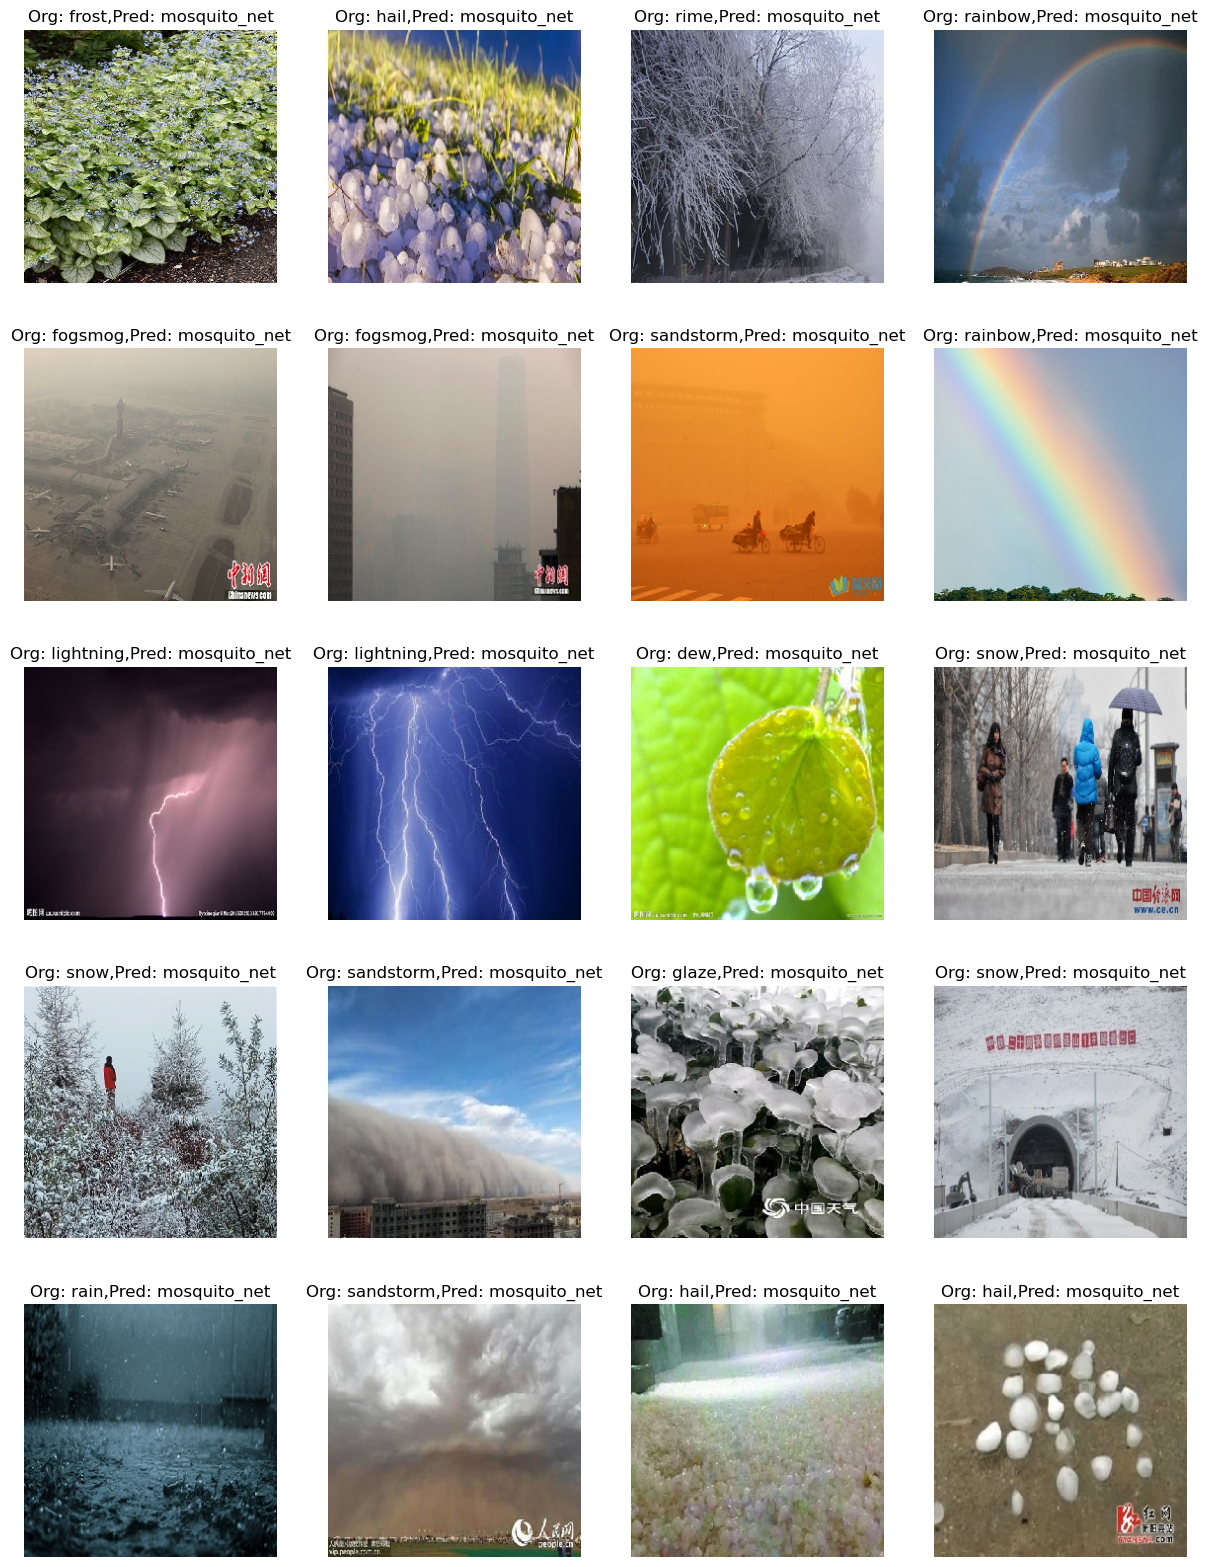

In [13]:
from keras.applications.vgg19 import decode_predictions

pred_reshaped = np.resize(pred_labels, (20,1000))
pred = decode_predictions(np.array(pred_reshaped))

plt.figure(figsize=(15,20))
for i in range(1, 21):
    plt.subplot(5, 4, i)
    plt.imshow(imageArr[i-1])
    plt.title(f"Org: {class_names[labelArr[i-1]]},Pred: {pred[i-1][0][1]}")
    plt.axis('off')
        
plt.show()

### Testowanie na większej próbce

In [14]:
tmp = np.array([])

k=0
for image, label in train_ds:
    new_size = (224, 224)

    resized_images = np.empty((32, *new_size, 3), dtype=np.uint8)

    for i in range(images.shape[0]):
        resized_images[i] = resize(images[i], new_size)

    image_features = vgg19_loaded.predict(resized_images)
    tmp = np.concatenate((tmp, np.argmax(image_features, axis=1)), axis=0)
    k += 1
    if k == 20: 
        break

tmp = np.unique(tmp, return_counts=True)

1/1 [==============================] - 0s 21ms/step


In [15]:
print(tmp)

(array([669.]), array([640]))


In [16]:
import urllib.request
import json

url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'

response = urllib.request.urlopen(url)
class_labels = json.loads(response.read())

for i, cont in zip(tmp[0], tmp[1]):
    print('Class number ', int(i), ' is "', class_labels[int(i)], '" predicted ', cont, ' times')

Class number  669  is " mosquito net " predicted  640  times


### Trenowanie zmodyfikowanego modelu

In [6]:
vgg19_loaded = VGG19(include_top=False, input_shape=(256,256,3))
vgg19_loaded.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [7]:
print_weights(vgg19_loaded)

trainable: 0.0, non-trainable: 20024384


In [11]:
vgg19 = Sequential([
    vgg19_loaded.layers[0],
    vgg19_loaded.layers[1],
    vgg19_loaded.layers[2],
    vgg19_loaded.layers[3],
    vgg19_loaded.layers[4],
    vgg19_loaded.layers[5],
    vgg19_loaded.layers[6],
    vgg19_loaded.layers[7],
    vgg19_loaded.layers[8],
    vgg19_loaded.layers[9],
    vgg19_loaded.layers[10],
    vgg19_loaded.layers[11],
    vgg19_loaded.layers[12],
    vgg19_loaded.layers[13],
    vgg19_loaded.layers[14],
    vgg19_loaded.layers[15],
    vgg19_loaded.layers[16],
    vgg19_loaded.layers[17],
    vgg19_loaded.layers[18],
    vgg19_loaded.layers[19],
    vgg19_loaded.layers[20],
    vgg19_loaded.layers[21],
    GAP(),
    Dense(256, activation="relu",
          kernel_regularizer=tf.keras.regularizers.L1(0.0001),
          activity_regularizer=tf.keras.regularizers.L2(0.00001)),
    Dropout(0.25),
    Dense(64, activation="relu",
          kernel_regularizer=tf.keras.regularizers.L1(0.0001),
          activity_regularizer=tf.keras.regularizers.L2(0.00001)),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
])

print_weights(vgg19)

trainable: 148491, non-trainable: 20024384


In [20]:
# keras.utils.plot_model(vgg19, show_shapes=True)
# vgg19.summary()
# vgg19.load_weights("/kaggle/working/model.h5")

In [21]:
def compile_model(model, train_data, valid_data, epochs = 160, learning_rate = 0.001):
        
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    time_start = time.time()

    model_data = model.fit(train_data,
                           epochs = epochs,
                           validation_data = valid_data)

    time_stop = time.time()

#     model.save_weights('/content/drive/MyDrive/WDZD/saved_weights/' + model.name)
    model.save_weights('model.h5')
#     model_data.history.

    return model_data, time_stop - time_start

In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
vgg19_data, time_ = compile_model(vgg19, train_ds, valid_ds, epochs = 50)

Epoch 1/50
153/153 [==============================] - 31s 168ms/step - loss: 2.4241 - accuracy: 0.3038 - val_loss: 1.8356 - val_accuracy: 0.5019
Epoch 2/50
153/153 [==============================] - 29s 192ms/step - loss: 1.7714 - accuracy: 0.4785 - val_loss: 1.4128 - val_accuracy: 0.6207
Epoch 3/50
153/153 [==============================] - 25s 160ms/step - loss: 1.5198 - accuracy: 0.5583 - val_loss: 1.3028 - val_accuracy: 0.6626
Epoch 4/50
153/153 [==============================] - 25s 163ms/step - loss: 1.3812 - accuracy: 0.5912 - val_loss: 1.1862 - val_accuracy: 0.6809
Epoch 5/50
153/153 [==============================] - 25s 163ms/step - loss: 1.3166 - accuracy: 0.6216 - val_loss: 1.1877 - val_accuracy: 0.6603
Epoch 6/50
153/153 [==============================] - 30s 195ms/step - loss: 1.2503 - accuracy: 0.6403 - val_loss: 1.0538 - val_accuracy: 0.7167
Epoch 7/50
153/153 [==============================] - 25s 161ms/step - loss: 1.1822 - accuracy: 0.6728 - val_loss: 1.0119 - val_ac

In [24]:
def print_time(timestamp):
    print('Time : ', timestamp, ' sec')


In [25]:
print_time(time_)

Time :  1593.9744672775269  sec


In [26]:
vgg19_data.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
def plot_subplot(ax, x, y, y_min, y_max, xlabel, ylabel):
    y = moving_average(y, 10)
    ax.plot(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(y_min, y_max)
    
def plot_loss_and_accuracy(model_history, train_loss = 2.5, test_loss=2.5):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axis_x = np.arange(1, EPOCHS + 1)  
    
    ax = axes[0, 0]
    plot_subplot(ax, axis_x, model_history.history['loss'], 0, train_loss, 'epoch', 'loss')
    ax.set_title('Train Set Loss')
    
    ax = axes[0, 1]
    plot_subplot(ax, axis_x, model_history.history['accuracy'], 0, 1.1, 'epoch', 'loss') # poprawiłam tutaj klucz 
    ax.set_title('Train Set Accuracy')
    
    ax = axes[1, 0]
    plot_subplot(ax, axis_x, model_history.history['val_loss'], 0, test_loss, 'epoch', 'loss')
    ax.set_title('Test Set Loss')
    
    ax = axes[1, 1]
    plot_subplot(ax, axis_x, model_history.history['val_accuracy'], 0, 1.1, 'epoch', 'loss') # i tutaj, bo nie było w tym history tego klucza co używałeś i dlatego wywalało błąd
    ax.set_title('Test Set Accuracy')
    
    plt.tight_layout()
    plt.show()
    
def moving_average(arr, n):
    cumsum = np.cumsum(np.concatenate(([0] * n, arr)))
    return (cumsum[n:] - cumsum[:-n]) / np.concatenate((np.arange(1, n + 1), np.full((len(arr) - n,), n)))

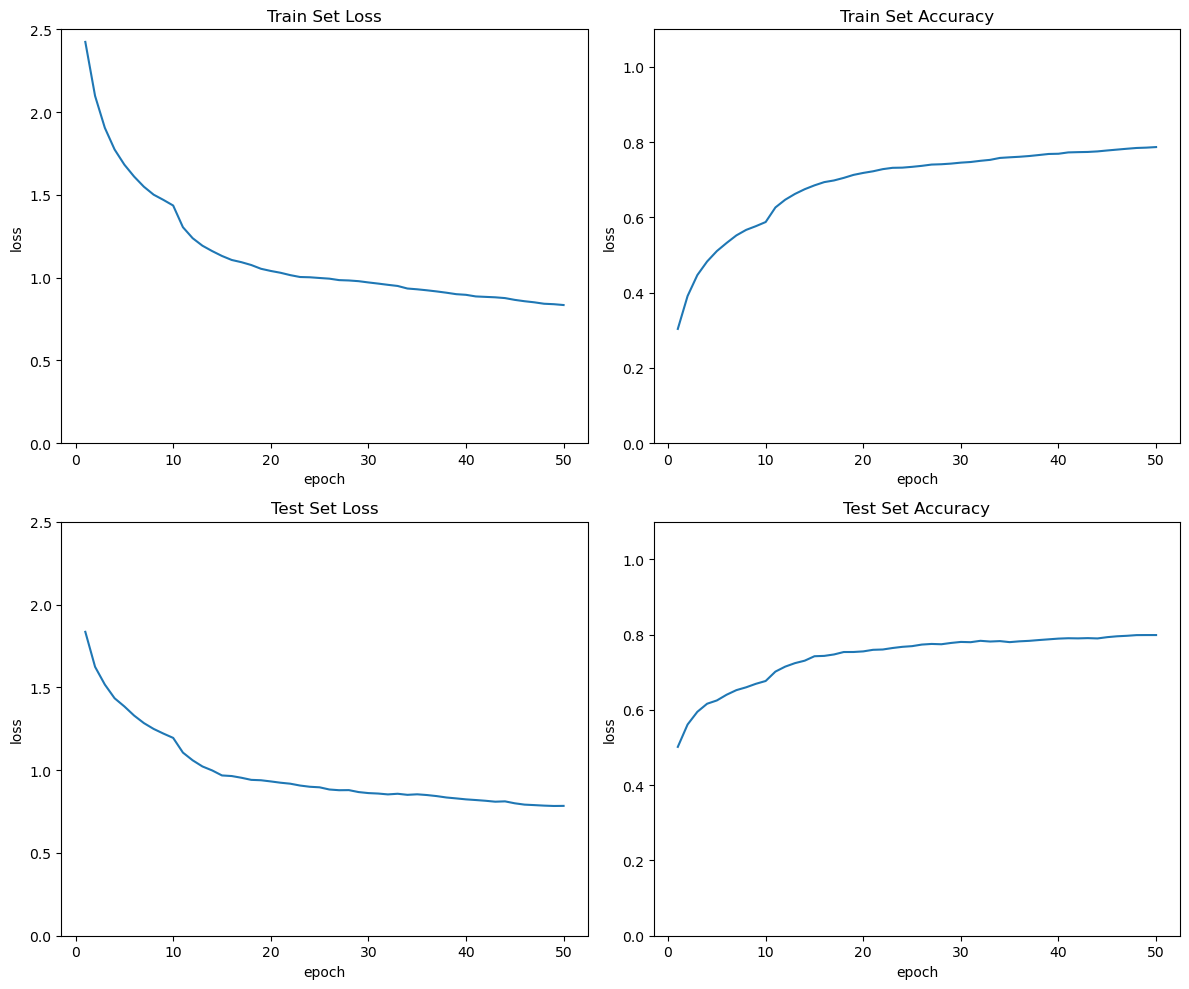

In [28]:
EPOCHS = 50
plot_loss_and_accuracy(vgg19_data)

### Predictions

In [36]:
X_test, Y_test = test_ds.next()  
X_test, Y_test = np.array(X_test), Y_test

In [37]:
predictions = vgg19.predict(X_test)

22/22 [==============================] - 2s 98ms/step


In [47]:
# print(predictions)
classes = np.argmax(predictions, axis=1)

<Axes: >

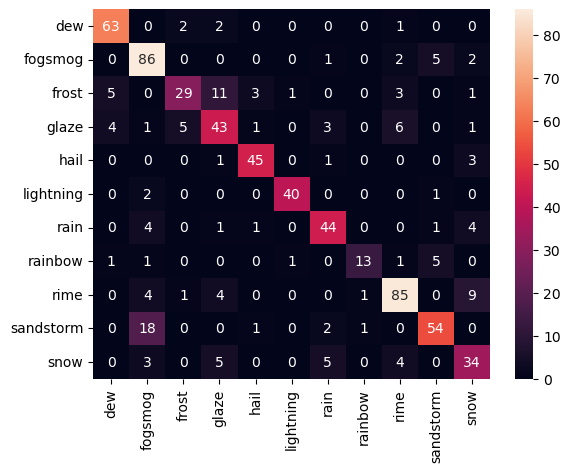

In [62]:
sns.heatmap(confusion_matrix(Y_test, classes), annot=True, xticklabels=class_names,yticklabels=class_names)

In [50]:
print(classification_report(Y_test, classes))

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89        68
         1.0       0.72      0.90      0.80        96
         2.0       0.78      0.55      0.64        53
         3.0       0.64      0.67      0.66        64
         4.0       0.88      0.90      0.89        50
         5.0       0.95      0.93      0.94        43
         6.0       0.79      0.80      0.79        55
         7.0       0.87      0.59      0.70        22
         8.0       0.83      0.82      0.83       104
         9.0       0.82      0.71      0.76        76
        10.0       0.63      0.67      0.65        51

    accuracy                           0.79       682
   macro avg       0.80      0.77      0.78       682
weighted avg       0.79      0.79      0.78       682



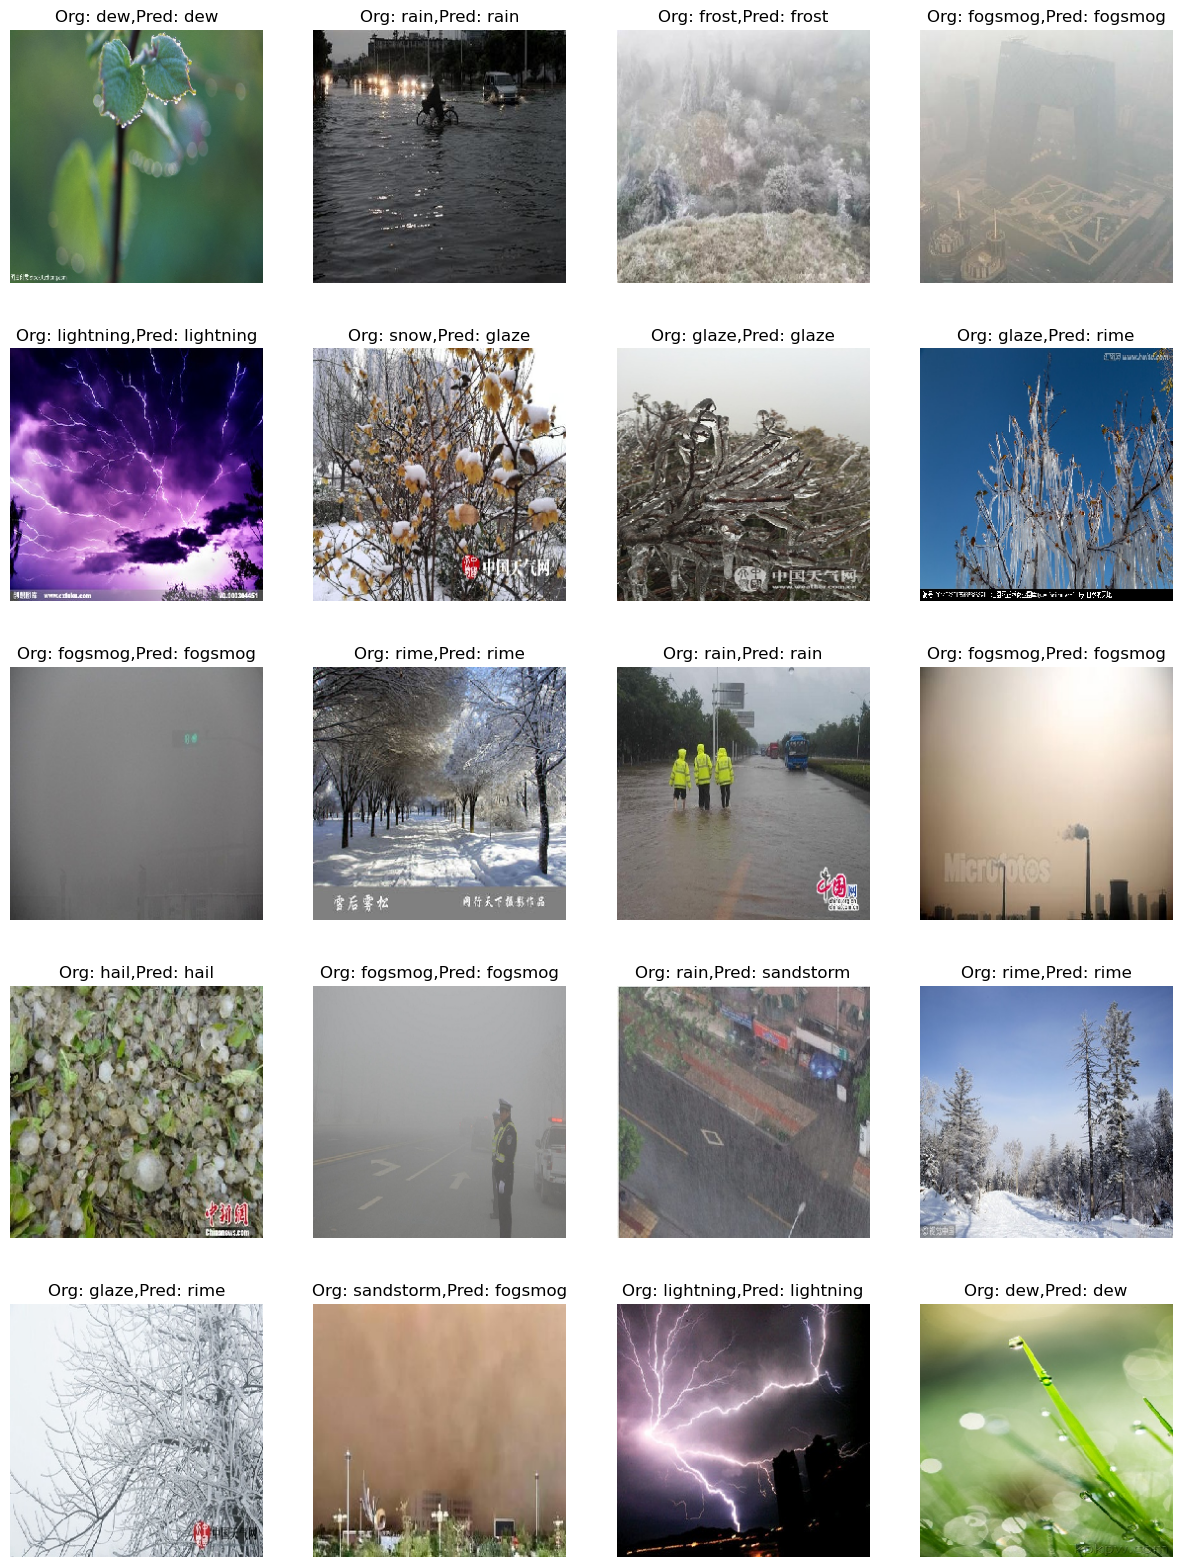

In [54]:
plt.figure(figsize=(15,20))

for i in range(1, 21):
    plt.subplot(5, 4, i)
    plt.imshow(X_test[i])
    plt.title(f"Org: {class_names[int(Y_test[i])]},Pred: {class_names[classes[i]]}")
    plt.axis('off')
        
plt.show()